# COVID-19 - analysis and prediction  


### Table of Contents:  
1. [Checking the data](#Checking-the-data)
2. [Testing the data](#Testing-data)
3. [SVM](#SVM)
    - [Confirmed cases](#Confirmed-cases)
    - [Number of deaths](#Number-of-deaths)
    - [Number of recovered cases](#Number-of-recovered-cases)
4. [Decision Tree](#Decision-Tree)

## Checking the data
First, it is required to analyse our dataset so that it is sure to not have any problems. To do so, we will print the first entries of the dataset:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv('data/covid19.csv', parse_dates=['Date'], infer_datetime_format=True)
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


The first problem we can identify is that some entries don't have a value on the *Country/Region* column.

We can fix this by assigning the value 'NA' to those entries:

In [2]:
# filling missing values 
data[['Province/State']] = data[['Province/State']].fillna('')
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,,Angola,-11.2027,17.8739,2020-01-22,0,0,0


There were some comments on Kaggle about repeated lines, it seems this is not the case.

In [3]:
duplicated_rows = data.duplicated()
duplicated_rows[duplicated_rows == True]

Series([], dtype: bool)

We can now take a look at some summary statistics about the data set:

In [4]:
data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2430.562420,147.948752,607.899531
std,24.740912,70.570899,23545.664313,1561.525918,5210.234488
min,-51.796300,-135.000000,-1.000000,-1.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,184.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


We see that the count is the same for values in the columns *Lat*, *Long*, *Confirmed*, *Deaths* and *Recovered*.

There is, however, something strange with this dataset: The minimum value for *Confirmed* and *Deaths* is -1. Because negative values don't make sense for these two columns, we will use **mean imputation** to replace them with the average number for each column.

In [5]:
average_confirmed_count = data['Confirmed'].mean()
data.loc[(data['Confirmed'] < 0), 'Confirmed'] = average_confirmed_count

average_death_count = data['Deaths'].mean()
data.loc[(data['Deaths'] < 0), 'Deaths'] = average_death_count

data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2432.399240,148.055347,607.899531
std,24.740912,70.570899,23545.569393,1561.520830,5210.234488
min,-51.796300,-135.000000,0.000000,0.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,185.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


Now  those columns make more sense.

Also, to ensure data integrity, we will replace any missing values with 0s.

In [6]:
data[['Confirmed', 'Deaths', 'Recovered']] = data[['Confirmed', 'Deaths', 'Recovered']].fillna(0)

### Testing data

In [7]:
assert len(data.loc[(data['Deaths'] < 0)]) == 0

assert len(data.loc[(data['Confirmed'] < 0)]) == 0

assert len(data.loc[(data['Recovered'] < 0)]) == 0

It would be a shame to lose all this tidied up data. Let's save it.

In [8]:
data.to_csv('data/covid19_clean.csv', index=False)

We'll now take a look at the scatterplot matrix now that we've tidied the data:

In [9]:
data_clean = pd.read_csv('data/covid19_clean.csv')
data_clean.fillna(data_clean.mean(), inplace=True)
# sb.pairplot(data.dropna())

---

# SVM

In [10]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

## Confirmed cases

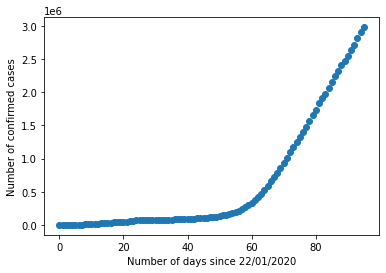

In [11]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

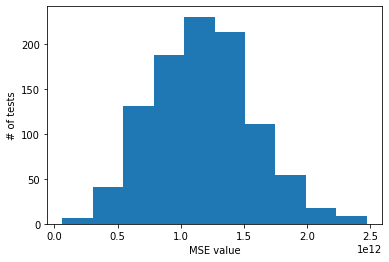

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

mse_values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(epidemic_days, world_cases, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    mse = mean_squared_error(X_test, y_test)
    mse_values.append(mse)
    
plt.hist(mse_values)
plt.xlabel('MSE value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  
We used MSE to evaluate the model performance since we are dealing with a regression model.  

### Testing for overfiting with K Folds

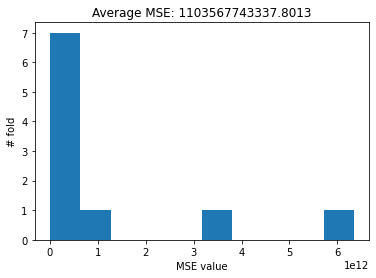

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

svm = SVR(kernel='poly')

scorer = make_scorer(mean_squared_error)

cv_scores = cross_val_score(svm, 
                            epidemic_days, 
                            world_cases.ravel(), 
                            cv=10, 
                            scoring=scorer)

plt.ylabel('# fold')
plt.xlabel('MSE value')
plt.hist(cv_scores)
plt.title('Average MSE: {}'.format(np.mean(cv_scores)))
plt.savefig('graphs/img1.png')
plt.show()

Using kfolds we were able to acheive a more consistant rating specially near 0.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernerl with a degree of 4. Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

*Beware this next block takes sometime to finish*

In [14]:
from sklearn.model_selection import GridSearchCV

svm = SVR(kernel='poly', degree=4)

parameter_grid = {'C': np.arange(1.0, 40, 0.5),
                  'epsilon': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10,
                           scoring='neg_mean_squared_error')

grid_search.fit(epidemic_days, world_cases.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 12224217849.235302
Best parameters: {'C': 23.0, 'epsilon': 0.01}


In [15]:
svm_confirmed = grid_search.best_estimator_
print(svm_confirmed.get_params())

{'C': 23.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 4, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


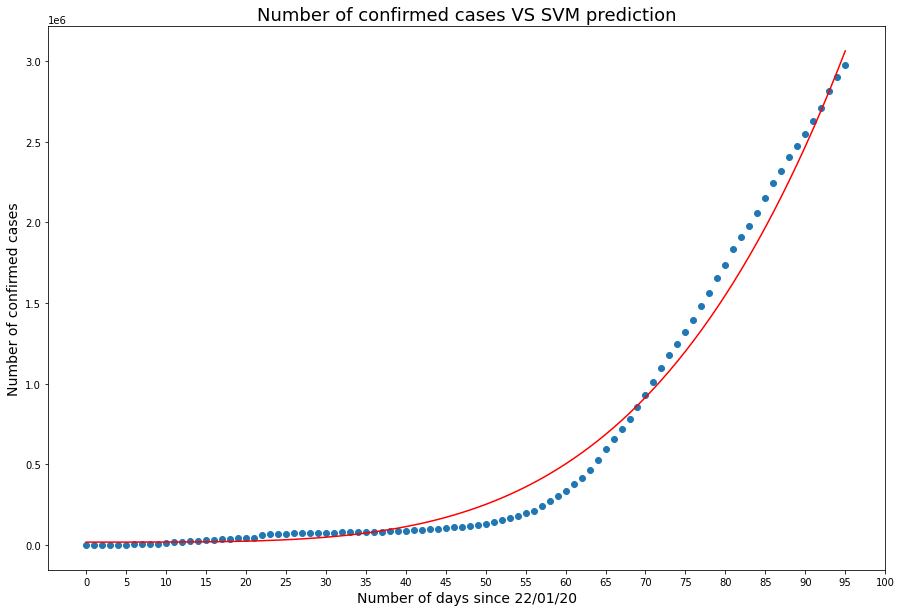

In [16]:
from sklearn.model_selection import cross_val_predict

scores = svm_confirmed.predict(epidemic_days)

# To predict an extra 10 days from the ones in the dataset
# test_days = np.array([i for i in range(len(dates) +10)]).reshape(-1, 1)
# test = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=epidemic_days, y=world_cases)
plt.plot(scores, color='red')
# plt.plot(aa, color='black')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+10, 5.0))
plt.title('Number of confirmed cases VS SVM prediction', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.savefig('graphs/svr_confirmed.png')
plt.show()

## Number of deaths

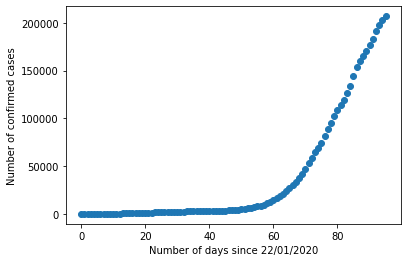

In [17]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

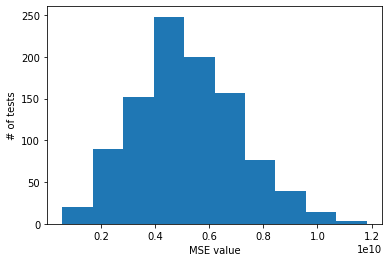

In [18]:
mse_values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(epidemic_days, world_deaths, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    mse = mean_squared_error(X_test, y_test)
    mse_values.append(mse)
    
plt.hist(mse_values)
plt.xlabel('MSE value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  
We used MSE to evaluate the model performance since we are dealing with a regression model.  

### Testing for overfiting with K Folds

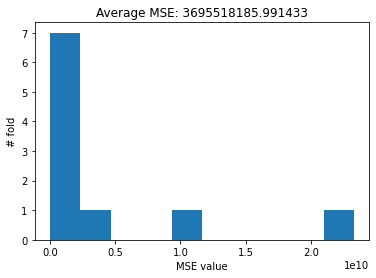

In [19]:
svm = SVR(kernel='poly')

scorer = make_scorer(mean_squared_error)

cv_scores = cross_val_score(svm, 
                            epidemic_days, 
                            world_deaths.ravel(), 
                            cv=10, 
                            scoring=scorer)

plt.ylabel('# fold')
plt.xlabel('MSE value')
plt.hist(cv_scores)
plt.title('Average MSE: {}'.format(np.mean(cv_scores)))
plt.show()

In [20]:
svm = SVR(kernel='poly', degree=4)

parameter_grid = {'C': np.arange(1.0, 40, 0.5),
                  'epsilon': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10,
                           scoring='neg_mean_squared_error')

grid_search.fit(epidemic_days, world_deaths.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 138081061.04791102
Best parameters: {'C': 6.0, 'epsilon': 0.01}


In [21]:
svm_deaths = grid_search.best_estimator_
print(svm_deaths.get_params())

{'C': 6.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 4, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


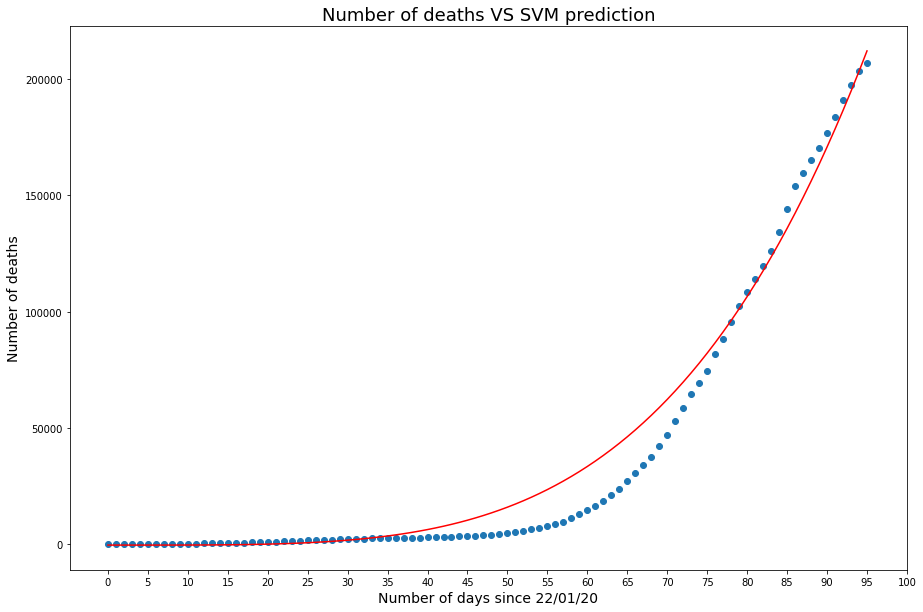

In [22]:
scores = svm_deaths.predict(epidemic_days)

# To predict an extra 10 days from the ones in the dataset
# test_days = np.array([i for i in range(len(dates) +10)]).reshape(-1, 1)

# test = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=epidemic_days, y=world_deaths)
plt.plot(scores, color='red')
# plt.plot(test, color='red')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+10, 5.0))
plt.title('Number of deaths VS SVM prediction', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.savefig('graphs/svr_deaths.png')
plt.show()

## Number of recovered cases

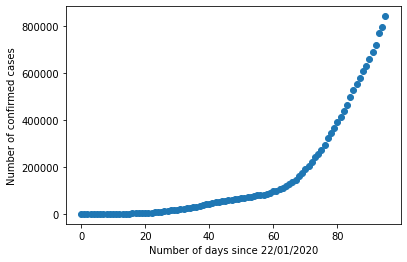

In [23]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

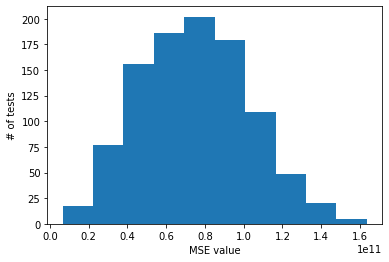

In [24]:
mse_values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(epidemic_days, world_recovered, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    mse = mean_squared_error(X_test, y_test)
    mse_values.append(mse)
    
plt.hist(mse_values)
plt.xlabel('MSE value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  
We used MSE to evaluate the model performance since we are dealing with a regression model.  

### Testing for overfiting with K Folds

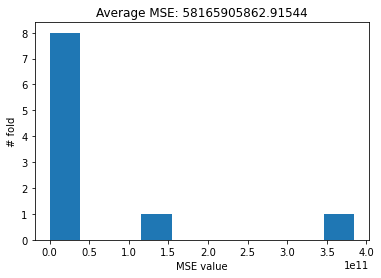

In [25]:
svm = SVR(kernel='poly')

scorer = make_scorer(mean_squared_error)

cv_scores = cross_val_score(svm, 
                            epidemic_days, 
                            world_recovered.ravel(), 
                            cv=10, 
                            scoring=scorer)

plt.ylabel('# fold')
plt.xlabel('MSE value')
plt.hist(cv_scores)
plt.title('Average MSE: {}'.format(np.mean(cv_scores)))
plt.show()

In [26]:
svm = SVR(kernel='poly', degree=4)

parameter_grid = {'C': np.arange(1.0, 40, 0.5),
                  'epsilon': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10,
                           scoring='neg_mean_squared_error')

grid_search.fit(epidemic_days, world_recovered.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 1086029778.4621997
Best parameters: {'C': 27.5, 'epsilon': 0.01}


In [27]:
svm_recoveries = grid_search.best_estimator_
print(svm_recoveries.get_params())

{'C': 27.5, 'cache_size': 200, 'coef0': 0.0, 'degree': 4, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


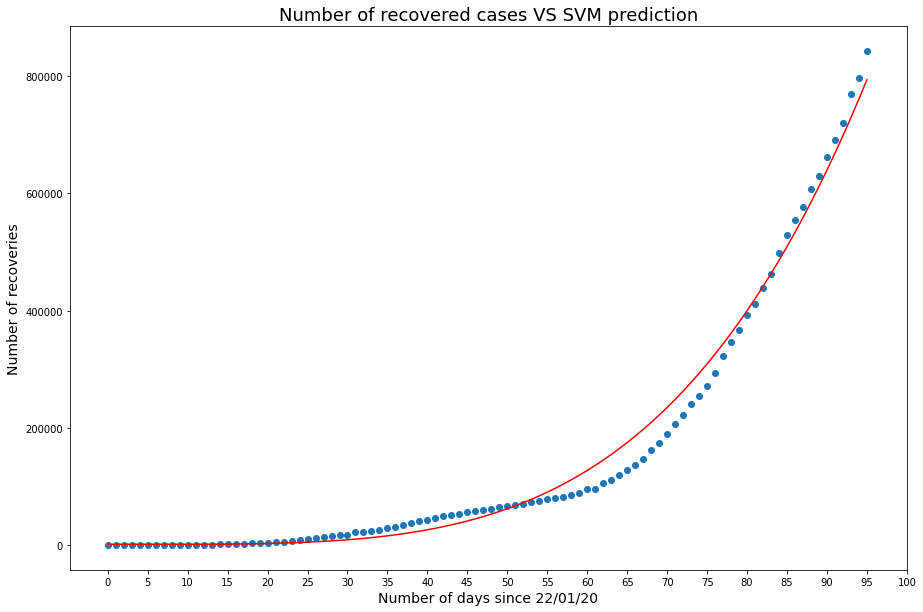

In [29]:
scores = svm_recoveries.predict(epidemic_days)

# To predict an extra 10 days from the ones in the dataset
# test_days = np.array([i for i in range(len(dates) +10)]).reshape(-1, 1)

# test = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=epidemic_days, y=world_recovered)
plt.plot(scores, color='red')
# plt.plot(test, color='red')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+10, 5.0))
plt.title('Number of recovered cases VS SVM prediction', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.savefig('graphs/svr_recovered.png')
plt.show()

## Decision Tree